In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
from rdkit.Chem import inchi
import molvs
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/3D_generative_SBDD
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from 3D_generative_SBDD

See if they are valid or not, standardize them

In [4]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [5]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/3D_generative_SBDD/combined_SMILES_10000.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules: 100%|██████████| 9955/9955 [23:00<00:00,  7.21mol/s]  

9955


9955

In [6]:
with open('combined_SMILES_10000_standardized.txt', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

Convert SMILES and name of them to a dataframe

In [6]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

SMILES
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...
...                                                 ...
9950                            O=C(O)c1cc(O)c(O)c(O)c1
9951                                    Oc1ccc(O)c(O)c1
9952                                C=CC=COc1cc(O)ccc1C
9953                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21
9954    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2

[9955 rows x 1 columns]

Add an RDKit molecule to the dataframe

In [7]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

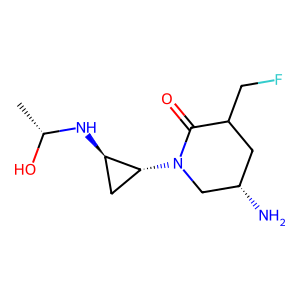

In [8]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [9]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                                     [C1CC1, O=C1CCCCN1]
1                                [O=C1CCCCN1, O=C1CCCCC1]
2                       [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]
3                          [C1CO1, C1CC[C@H]2NCN[C@H]2C1]
4       [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...
                              ...                        
9950                                           [c1ccccc1]
9951                                           [c1ccccc1]
9952                                           [c1ccccc1]
9953                                  [O=C1CC[C@H]2CC2C1]
9954                              [O=C1CCC[C@H]2C[C@H]12]
Name: ring_sytems, Length: 9955, dtype: object

In [10]:
df.ring_sytems.values

array([list(['C1CC1', 'O=C1CCCCN1']), list(['O=C1CCCCN1', 'O=C1CCCCC1']),
       list(['O=C1CCCCN1', 'C1C[C@H]2O[C@@H]2C1']), ...,
       list(['c1ccccc1']), list(['O=C1CC[C@H]2CC2C1']),
       list(['O=C1CCC[C@H]2C[C@H]12'])], dtype=object)

See how many times each ring system occurs

In [11]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

SMILES  Count
78                                             c1ccccc1   1264
8                                                 C1CN1    958
4                                                 C1CO1    908
0                                                 C1CC1    785
22                                             C1CCNCC1    260
...                                                 ...    ...
24                                      N=C1CCCC2NCNC12      1
26                 C1CC[C@H]2NCC[C@@H]3O[C@@H]3[C@H]2C1      1
27                        C1C[C@H]2N[C@H]2CCN2C[C@@H]12      1
30                                 C1=C[C@H]2O[C@@H]2O1      1
1109  O=C1OCC[C@@H]2[C@@H]3O[C@@]34N=c3ccncc3=CC4[C@...      1

[3695 rows x 2 columns]

View the ring system frequencies

In [12]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [13]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

[14:40:52] unrecognized chirality tag (6) on atom 2 is ignored.


In [14]:
res

0                    [(C1CC1, 90040), (O=C1CCCCN1, 4720)]
1                 [(O=C1CCCCN1, 4720), (O=C1CCCCC1, 862)]
2          [(O=C1CCCCN1, 4720), (C1C[C@H]2O[C@@H]2C1, 0)]
3             [(C1CO1, 3085), (C1CC[C@H]2NCN[C@H]2C1, 2)]
4       [(C1CO1, 3085), (C1CN[C@@H]2CCC[C@H]3[C@@H]2[C...
                              ...                        
9950                                [(c1ccccc1, 2568039)]
9951                                [(c1ccccc1, 2568039)]
9952                                [(c1ccccc1, 2568039)]
9953                             [(O=C1CC[C@H]2CC2C1, 0)]
9954                         [(O=C1CCC[C@H]2C[C@H]12, 0)]
Name: mol, Length: 9955, dtype: object

In [15]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9950                            O=C(O)c1cc(O)c(O)c(O)c1   
9951                                    Oc1ccc(O)c(O)c1   
9952                                C=CC=COc1cc(O)ccc1C   
9953                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9954    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9950  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9951  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9952  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9953  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9954  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9950                                         [c1ccccc1]   
9951                                         [c1ccccc1]   
9952                                         [c1ccccc1]   
9953                                [O=C1CC[C@H]2CC2C1]   
9954                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring min_freq  
0                                          O=C1CCCCN1     4720  
1                                          O=C1CCCCC1      862  
2                                 C1C[C@H]2O[C@@H]2C1        0  
3                               C1CC[C@H]2NCN[C@H]2C1        2  
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13        0  
...                                               ...      ...  
9950                                         c1ccccc1  2568039  
9951                                         c1ccccc1  2568039  
9952                                         c1ccccc1  2568039  
9953                                O=C1CC[C@H]2CC2C1        0  
9954                            O=C1CCC[C@H]2C[C@H]12        0  

[9955 rows x 5 columns]

In [16]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [17]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefined stereo

[14:41:10] WARNING: Omitted undefi

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9798                                         [c1ccccc1]   
9799                                         [c1ccccc1]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring min_freq  \
0                                          O=C1CCCCN1     4720   
1                                          O=C1CCCCC1      862   
2                                 C1C[C@H]2O[C@@H]2C1        0   
3                               C1CC[C@H]2NCN[C@H]2C1        2   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13        0   
...                                               ...      ...   
9798                                         c1ccccc1  2568039   
9799                                         c1ccccc1  2568039   
9800                                         c1ccccc1  2568039   
9801                                O=C1CC[C@H]2CC2C1        0   
9802                            O=C1CCC[C@H]2C[C@H]12        0   

                                                  inchi  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...  
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...  
...                                                 ...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...  
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...  

[9803 rows x 6 columns]

How many molecules contains ring structure?

In [18]:
df_ring = df[df.min_freq != -1]
df_ring

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9798                                         [c1ccccc1]   
9799                                         [c1ccccc1]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring min_freq  \
0                                          O=C1CCCCN1     4720   
1                                          O=C1CCCCC1      862   
2                                 C1C[C@H]2O[C@@H]2C1        0   
3                               C1CC[C@H]2NCN[C@H]2C1        2   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13        0   
...                                               ...      ...   
9798                                         c1ccccc1  2568039   
9799                                         c1ccccc1  2568039   
9800                                         c1ccccc1  2568039   
9801                                O=C1CC[C@H]2CC2C1        0   
9802                            O=C1CCC[C@H]2C[C@H]12        0   

                                                  inchi  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...  
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...  
...                                                 ...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...  
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...  

[8952 rows x 6 columns]

In [19]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
5        N[C@H]1CC([C@@H](O)F)C(=O)N(C(CO)C(=O)C(O)O)C1   
7     O[C@@H](N1C[C@@H]1C[C@H]1N[C@@H]1CF)[C@]1(O)O[...   
8                 CC(C(=O)C(O)CO)N1C[C@@H](N)CC(CF)C1=O   
...                                                 ...   
9796                                   Cc1cc(O)c(O)cc1O   
9797                    OC[C@@H]1COc2c(O)cc(C(O)O)cc2O1   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
5     <rdkit.Chem.rdchem.Mol object at 0x742178e79620>   
7     <rdkit.Chem.rdchem.Mol object at 0x742178e79700>   
8     <rdkit.Chem.rdchem.Mol object at 0x742178e79770>   
...                                                ...   
9796  <rdkit.Chem.rdchem.Mol object at 0x742178d8ba00>   
9797  <rdkit.Chem.rdchem.Mol object at 0x742178d8ba70>   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   

                       ring_sytems          min_ring min_freq  \
0              [C1CC1, O=C1CCCCN1]        O=C1CCCCN1     4720   
1         [O=C1CCCCN1, O=C1CCCCC1]        O=C1CCCCC1      862   
5                     [O=C1CCCCN1]        O=C1CCCCN1     4720   
7     [C1CN1, C1CN1, C1CO1, C1CO1]             C1CN1     1557   
8                     [O=C1CCCCN1]        O=C1CCCCN1     4720   
...                            ...               ...      ...   
9796                    [c1ccccc1]          c1ccccc1  2568039   
9797            [c1ccc2c(c1)OCCO2]  c1ccc2c(c1)OCCO2    12785   
9798                    [c1ccccc1]          c1ccccc1  2568039   
9799                    [c1ccccc1]          c1ccccc1  2568039   
9800                    [c1ccccc1]          c1ccccc1  2568039   

                                                  inchi  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...  
5     InChI=1S/C10H17FN2O6/c11-8(16)5-1-4(12)2-13(9(...  
7     InChI=1S/C11H17FN2O4/c12-2-7-6(13-7)1-5-3-14(5...  
8     InChI=1S/C11H19FN2O4/c1-6(10(17)9(16)5-15)14-4...  
...                                                 ...  
9796  InChI=1S/C7H8O3/c1-4-2-6(9)7(10)3-5(4)8/h2-3,8...  
9797  InChI=1S/C10H12O6/c11-3-6-4-15-9-7(12)1-5(10(1...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...  

[2856 rows x 6 columns]

### How many of them could pass PAINS filter?

Get a list of rules

In [20]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [21]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [22]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [23]:
new_df = reos.pandas_mols(df.mol)
len(new_df[new_df.description == "ok"])

  0%|          | 0/9803 [00:00<?, ?it/s]

9344

In [24]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/9803 [00:00<?, ?it/s]

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9795                        O[C@@H]1C=CC=C2[C@H](O)C21O   
9797                    OC[C@@H]1COc2c(O)cc(C(O)O)cc2O1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9795  <rdkit.Chem.rdchem.Mol object at 0x742178d8b990>   
9797  <rdkit.Chem.rdchem.Mol object at 0x742178d8ba70>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9795                                    [C1=CCC2CC2=C1]   
9797                                 [c1ccc2c(c1)OCCO2]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring min_freq  \
0                                          O=C1CCCCN1     4720   
1                                          O=C1CCCCC1      862   
2                                 C1C[C@H]2O[C@@H]2C1        0   
3                               C1CC[C@H]2NCN[C@H]2C1        2   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13        0   
...                                               ...      ...   
9795                                    C1=CCC2CC2=C1        0   
9797                                 c1ccc2c(c1)OCCO2    12785   
9800                                         c1ccccc1  2568039   
9801                                O=C1CC[C@H]2CC2C1        0   
9802                            O=C1CCC[C@H]2C[C@H]12        0   

                                                  inchi rule_set_name  \
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...            ok   
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...            ok   
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...            ok   
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...            ok   
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...            ok   
...                                                 ...           ...   
9795  InChI=1S/C7H8O3/c8-5-3-1-2-4-6(9)7(4,5)10/h1-3...            ok   
9797  InChI=1S/C10H12O6/c11-3-6-4-15-9-7(12)1-5(10(1...            ok   
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...            ok   
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...            ok   
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...            ok   

     description  
0             ok  
1             ok  
2             ok  
3             ok  
4             ok  
...          ...  
9795          ok  
9797          ok  
9800          ok  
9801          ok  
9802          ok  

[9344 rows x 8 columns]

Test all filters in rd_filter

In [25]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/9803 [00:00<?, ?it/s]

Glaxo 0.5988982964398654 ['Glaxo'] 5871


  0%|          | 0/9803 [00:00<?, ?it/s]

Dundee 0.2729776599000306 ['Dundee'] 2676


  0%|          | 0/9803 [00:00<?, ?it/s]

BMS 0.4988268897276344 ['BMS'] 4890


  0%|          | 0/9803 [00:00<?, ?it/s]

SureChEMBL 0.4860756911149648 ['SureChEMBL'] 4765


  0%|          | 0/9803 [00:00<?, ?it/s]

MLSMR 0.35325920636539837 ['MLSMR'] 3463


  0%|          | 0/9803 [00:00<?, ?it/s]

Inpharmatica 0.49821483219422624 ['Inpharmatica'] 4884


  0%|          | 0/9803 [00:00<?, ?it/s]

LINT 0.4064062021830052 ['LINT'] 3984


### How many of them could pass filters suggested by Dr.Reymond?

In [26]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9798                                         [c1ccccc1]   
9799                                         [c1ccccc1]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring min_freq  \
0                                          O=C1CCCCN1     4720   
1                                          O=C1CCCCC1      862   
2                                 C1C[C@H]2O[C@@H]2C1        0   
3                               C1CC[C@H]2NCN[C@H]2C1        2   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13        0   
...                                               ...      ...   
9798                                         c1ccccc1  2568039   
9799                                         c1ccccc1  2568039   
9800                                         c1ccccc1  2568039   
9801                                O=C1CC[C@H]2CC2C1        0   
9802                            O=C1CCC[C@H]2C[C@H]12        0   

                                                  inchi  Reymond  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...     True  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...     True  
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...     True  
...                                                 ...      ...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True  
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...     True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True  

[9803 rows x 7 columns]

In [27]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9798                                         [c1ccccc1]   
9799                                         [c1ccccc1]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring min_freq  \
0                                          O=C1CCCCN1     4720   
1                                          O=C1CCCCC1      862   
2                                 C1C[C@H]2O[C@@H]2C1        0   
3                               C1CC[C@H]2NCN[C@H]2C1        2   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13        0   
...                                               ...      ...   
9798                                         c1ccccc1  2568039   
9799                                         c1ccccc1  2568039   
9800                                         c1ccccc1  2568039   
9801                                O=C1CC[C@H]2CC2C1        0   
9802                            O=C1CCC[C@H]2C[C@H]12        0   

                                                  inchi  Reymond  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...     True  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...     True  
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...     True  
...                                                 ...      ...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True  
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...     True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True  

[9185 rows x 7 columns]

### How many of them could pass RO5?

In [28]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9798                                         [c1ccccc1]   
9799                                         [c1ccccc1]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring min_freq  \
0                                          O=C1CCCCN1     4720   
1                                          O=C1CCCCC1      862   
2                                 C1C[C@H]2O[C@@H]2C1        0   
3                               C1CC[C@H]2NCN[C@H]2C1        2   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13        0   
...                                               ...      ...   
9798                                         c1ccccc1  2568039   
9799                                         c1ccccc1  2568039   
9800                                         c1ccccc1  2568039   
9801                                O=C1CC[C@H]2CC2C1        0   
9802                            O=C1CCC[C@H]2C[C@H]12        0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True      True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True      True  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...     True      True  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...     True      True  
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...     True      True  
...                                                 ...      ...       ...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True      True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True      True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True      True  
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...     True      True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True      True  

[9803 rows x 8 columns]

In [29]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9798                                         [c1ccccc1]   
9799                                         [c1ccccc1]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring min_freq  \
0                                          O=C1CCCCN1     4720   
1                                          O=C1CCCCC1      862   
2                                 C1C[C@H]2O[C@@H]2C1        0   
3                               C1CC[C@H]2NCN[C@H]2C1        2   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13        0   
...                                               ...      ...   
9798                                         c1ccccc1  2568039   
9799                                         c1ccccc1  2568039   
9800                                         c1ccccc1  2568039   
9801                                O=C1CC[C@H]2CC2C1        0   
9802                            O=C1CCC[C@H]2C[C@H]12        0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True      True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True      True  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...     True      True  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...     True      True  
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...     True      True  
...                                                 ...      ...       ...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True      True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True      True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True      True  
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...     True      True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True      True  

[8667 rows x 8 columns]

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [31]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

[14:44:41] unrecognized chirality tag (6) on atom 2 is ignored.


0         [(C1CC1, 17361841694), (O=C1CCCCN1, 577999208)]
1       [(O=C1CCCCN1, 577999208), (O=C1CCCCC1, 91122730)]
2       [(O=C1CCCCN1, 577999208), (C1C[C@H]2O[C@@H]2C1...
3          [(C1CO1, 350284), (C1CC[C@H]2NCN[C@H]2C1, 50)]
4       [(C1CO1, 350284), (C1CN[C@@H]2CCC[C@H]3[C@@H]2...
                              ...                        
9798                            [(c1ccccc1, 21243538754)]
9799                            [(c1ccccc1, 21243538754)]
9800                            [(c1ccccc1, 21243538754)]
9801                             [(O=C1CC[C@H]2CC2C1, 0)]
9802                     [(O=C1CCC[C@H]2C[C@H]12, 24614)]
Name: mol, Length: 9803, dtype: object

In [32]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9798                                         [c1ccccc1]   
9799                                         [c1ccccc1]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring     min_freq  \
0                                          O=C1CCCCN1    577999208   
1                                          O=C1CCCCC1     91122730   
2                                 C1C[C@H]2O[C@@H]2C1           48   
3                               C1CC[C@H]2NCN[C@H]2C1           50   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13            0   
...                                               ...          ...   
9798                                         c1ccccc1  21243538754   
9799                                         c1ccccc1  21243538754   
9800                                         c1ccccc1  21243538754   
9801                                O=C1CC[C@H]2CC2C1            0   
9802                            O=C1CCC[C@H]2C[C@H]12        24614   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True      True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True      True  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...     True      True  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...     True      True  
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...     True      True  
...                                                 ...      ...       ...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True      True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True      True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True      True  
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...     True      True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True      True  

[9803 rows x 8 columns]

In [33]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

Since we already used inchi key to remove redundance, no need to do it again.

In [34]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
5        N[C@H]1CC([C@@H](O)F)C(=O)N(C(CO)C(=O)C(O)O)C1   
6              CC(F)=C1C[C@H](N)CN(C(CO)C(=O)C(O)O)C1=O   
7     O[C@@H](N1C[C@@H]1C[C@H]1N[C@@H]1CF)[C@]1(O)O[...   
...                                                 ...   
9797                    OC[C@@H]1COc2c(O)cc(C(O)O)cc2O1   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
5     <rdkit.Chem.rdchem.Mol object at 0x742178e79620>   
6     <rdkit.Chem.rdchem.Mol object at 0x742178e79690>   
7     <rdkit.Chem.rdchem.Mol object at 0x742178e79700>   
...                                                ...   
9797  <rdkit.Chem.rdchem.Mol object at 0x742178d8ba70>   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                       ring_sytems               min_ring     min_freq  \
0              [C1CC1, O=C1CCCCN1]             O=C1CCCCN1    577999208   
1         [O=C1CCCCN1, O=C1CCCCC1]             O=C1CCCCC1     91122730   
5                     [O=C1CCCCN1]             O=C1CCCCN1    577999208   
6                   [C=C1CCCNC1=O]           C=C1CCCNC1=O         1320   
7     [C1CN1, C1CN1, C1CO1, C1CO1]                  C1CO1       350284   
...                            ...                    ...          ...   
9797            [c1ccc2c(c1)OCCO2]       c1ccc2c(c1)OCCO2     72850116   
9798                    [c1ccccc1]               c1ccccc1  21243538754   
9799                    [c1ccccc1]               c1ccccc1  21243538754   
9800                    [c1ccccc1]               c1ccccc1  21243538754   
9802       [O=C1CCC[C@H]2C[C@H]12]  O=C1CCC[C@H]2C[C@H]12        24614   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True      True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True      True  
5     InChI=1S/C10H17FN2O6/c11-8(16)5-1-4(12)2-13(9(...     True      True  
6     InChI=1S/C11H17FN2O5/c1-5(12)7-2-6(13)3-14(10(...     True      True  
7     InChI=1S/C11H17FN2O4/c12-2-7-6(13-7)1-5-3-14(5...     True      True  
...                                                 ...      ...       ...  
9797  InChI=1S/C10H12O6/c11-3-6-4-15-9-7(12)1-5(10(1...     True      True  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True      True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True      True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True      True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True      True  

[3441 rows x 8 columns]

In [35]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
5        N[C@H]1CC([C@@H](O)F)C(=O)N(C(CO)C(=O)C(O)O)C1   
...                                                 ...   
9797                    OC[C@@H]1COc2c(O)cc(C(O)O)cc2O1   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
5     <rdkit.Chem.rdchem.Mol object at 0x742178e79620>   
...                                                ...   
9797  <rdkit.Chem.rdchem.Mol object at 0x742178d8ba70>   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                            ring_sytems               min_ring     min_freq  \
0                   [C1CC1, O=C1CCCCN1]             O=C1CCCCN1    577999208   
1              [O=C1CCCCN1, O=C1CCCCC1]             O=C1CCCCC1     91122730   
2     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]    C1C[C@H]2O[C@@H]2C1           48   
3        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]  C1CC[C@H]2NCN[C@H]2C1           50   
5                          [O=C1CCCCN1]             O=C1CCCCN1    577999208   
...                                 ...                    ...          ...   
9797                 [c1ccc2c(c1)OCCO2]       c1ccc2c(c1)OCCO2     72850116   
9798                         [c1ccccc1]               c1ccccc1  21243538754   
9799                         [c1ccccc1]               c1ccccc1  21243538754   
9800                         [c1ccccc1]               c1ccccc1  21243538754   
9802            [O=C1CCC[C@H]2C[C@H]12]  O=C1CCC[C@H]2C[C@H]12        24614   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True      True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True      True  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...     True      True  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...     True      True  
5     InChI=1S/C10H17FN2O6/c11-8(16)5-1-4(12)2-13(9(...     True      True  
...                                                 ...      ...       ...  
9797  InChI=1S/C10H12O6/c11-3-6-4-15-9-7(12)1-5(10(1...     True      True  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True      True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True      True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True      True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True      True  

[4060 rows x 8 columns]

In [36]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
5        N[C@H]1CC([C@@H](O)F)C(=O)N(C(CO)C(=O)C(O)O)C1   
...                                                 ...   
9797                    OC[C@@H]1COc2c(O)cc(C(O)O)cc2O1   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
5     <rdkit.Chem.rdchem.Mol object at 0x742178e79620>   
...                                                ...   
9797  <rdkit.Chem.rdchem.Mol object at 0x742178d8ba70>   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                            ring_sytems               min_ring     min_freq  \
0                   [C1CC1, O=C1CCCCN1]             O=C1CCCCN1    577999208   
1              [O=C1CCCCN1, O=C1CCCCC1]             O=C1CCCCC1     91122730   
2     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]    C1C[C@H]2O[C@@H]2C1           48   
3        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]  C1CC[C@H]2NCN[C@H]2C1           50   
5                          [O=C1CCCCN1]             O=C1CCCCN1    577999208   
...                                 ...                    ...          ...   
9797                 [c1ccc2c(c1)OCCO2]       c1ccc2c(c1)OCCO2     72850116   
9798                         [c1ccccc1]               c1ccccc1  21243538754   
9799                         [c1ccccc1]               c1ccccc1  21243538754   
9800                         [c1ccccc1]               c1ccccc1  21243538754   
9802            [O=C1CCC[C@H]2C[C@H]12]  O=C1CCC[C@H]2C[C@H]12        24614   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True      True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True      True  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...     True      True  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...     True      True  
5     InChI=1S/C10H17FN2O6/c11-8(16)5-1-4(12)2-13(9(...     True      True  
...                                                 ...      ...       ...  
9797  InChI=1S/C10H12O6/c11-3-6-4-15-9-7(12)1-5(10(1...     True      True  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True      True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True      True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True      True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True      True  

[3793 rows x 8 columns]

### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [37]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

[14:44:59] unrecognized chirality tag (6) on atom 2 is ignored.


0              [(C1CC1, 99962598), (O=C1CCCCN1, 7760527)]
1           [(O=C1CCCCN1, 7760527), (O=C1CCCCC1, 506911)]
2       [(O=C1CCCCN1, 7760527), (C1C[C@H]2O[C@@H]2C1, ...
3            [(C1CO1, 8209), (C1CC[C@H]2NCN[C@H]2C1, 25)]
4       [(C1CO1, 8209), (C1CN[C@@H]2CCC[C@H]3[C@@H]2[C...
                              ...                        
9798                              [(c1ccccc1, 503413992)]
9799                              [(c1ccccc1, 503413992)]
9800                              [(c1ccccc1, 503413992)]
9801                             [(O=C1CC[C@H]2CC2C1, 0)]
9802                         [(O=C1CCC[C@H]2C[C@H]12, 4)]
Name: mol, Length: 9803, dtype: object

In [38]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
2     CC1C[C@H](N)CN(C[C@@]23C[C@H](O)[C@@H](O)[C@H]...   
3           O=C(O)[C@@]1(N[C@H]2CC[C@H]3NCN[C@H]3C2)CO1   
4     O[C@@]1([C@@H]2[C@@H]3O[C@H]4CCCN[C@@H]5CCC[C@...   
...                                                 ...   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   
9801                   CCC[C@H]1CC(=O)C(CCO)C2C[C@@H]21   
9802    C=CC[C@@]12C[C@@H](O)C([C@H](C)CO)C(=O)[C@H]1C2   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
2     <rdkit.Chem.rdchem.Mol object at 0x742178e794d0>   
3     <rdkit.Chem.rdchem.Mol object at 0x742178e79540>   
4     <rdkit.Chem.rdchem.Mol object at 0x742178e795b0>   
...                                                ...   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   
9801  <rdkit.Chem.rdchem.Mol object at 0x742178d8bc30>   
9802  <rdkit.Chem.rdchem.Mol object at 0x742178d8bca0>   

                                            ring_sytems  \
0                                   [C1CC1, O=C1CCCCN1]   
1                              [O=C1CCCCN1, O=C1CCCCC1]   
2                     [O=C1CCCCN1, C1C[C@H]2O[C@@H]2C1]   
3                        [C1CO1, C1CC[C@H]2NCN[C@H]2C1]   
4     [C1CO1, C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[...   
...                                                 ...   
9798                                         [c1ccccc1]   
9799                                         [c1ccccc1]   
9800                                         [c1ccccc1]   
9801                                [O=C1CC[C@H]2CC2C1]   
9802                            [O=C1CCC[C@H]2C[C@H]12]   

                                             min_ring   min_freq  \
0                                          O=C1CCCCN1    7760527   
1                                          O=C1CCCCC1     506911   
2                                 C1C[C@H]2O[C@@H]2C1         24   
3                               C1CC[C@H]2NCN[C@H]2C1         25   
4     C1CN[C@@H]2CCC[C@H]3[C@@H]2[C@H](C1)O[C@H]1CN13          0   
...                                               ...        ...   
9798                                         c1ccccc1  503413992   
9799                                         c1ccccc1  503413992   
9800                                         c1ccccc1  503413992   
9801                                O=C1CC[C@H]2CC2C1          0   
9802                            O=C1CCC[C@H]2C[C@H]12          4   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True      True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True      True  
2     InChI=1S/C12H20N2O4/c1-6-2-7(13)4-14(11(6)17)5...     True      True  
3     InChI=1S/C10H17N3O3/c14-9(15)10(4-16-10)13-6-1...     True      True  
4     InChI=1S/C14H22N2O3/c17-14(7-18-14)12-13-16(12...     True      True  
...                                                 ...      ...       ...  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True      True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True      True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True      True  
9801  InChI=1S/C12H20O2/c1-2-3-8-6-12(14)9(4-5-13)11...     True      True  
9802  InChI=1S/C13H20O3/c1-3-4-13-5-9(13)12(16)11(8(...     True      True  

[9803 rows x 8 columns]

In [39]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [40]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0       C[C@@H](O)N[C@@H]1C[C@H]1N1C[C@@H](N)CC(CF)C1=O   
1               N[C@H]1CC(CF)C(=O)N(C2CCC(=O)C(O)C2O)C1   
5        N[C@H]1CC([C@@H](O)F)C(=O)N(C(CO)C(=O)C(O)O)C1   
7     O[C@@H](N1C[C@@H]1C[C@H]1N[C@@H]1CF)[C@]1(O)O[...   
8                 CC(C(=O)C(O)CO)N1C[C@@H](N)CC(CF)C1=O   
...                                                 ...   
9796                                   Cc1cc(O)c(O)cc1O   
9797                    OC[C@@H]1COc2c(O)cc(C(O)O)cc2O1   
9798                            O=C(O)c1cc(O)c(O)c(O)c1   
9799                                    Oc1ccc(O)c(O)c1   
9800                                C=CC=COc1cc(O)ccc1C   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x742179db2b90>   
1     <rdkit.Chem.rdchem.Mol object at 0x742178e79460>   
5     <rdkit.Chem.rdchem.Mol object at 0x742178e79620>   
7     <rdkit.Chem.rdchem.Mol object at 0x742178e79700>   
8     <rdkit.Chem.rdchem.Mol object at 0x742178e79770>   
...                                                ...   
9796  <rdkit.Chem.rdchem.Mol object at 0x742178d8ba00>   
9797  <rdkit.Chem.rdchem.Mol object at 0x742178d8ba70>   
9798  <rdkit.Chem.rdchem.Mol object at 0x742178d8bae0>   
9799  <rdkit.Chem.rdchem.Mol object at 0x742178d8bb50>   
9800  <rdkit.Chem.rdchem.Mol object at 0x742178d8bbc0>   

                       ring_sytems          min_ring   min_freq  \
0              [C1CC1, O=C1CCCCN1]        O=C1CCCCN1    7760527   
1         [O=C1CCCCN1, O=C1CCCCC1]        O=C1CCCCC1     506911   
5                     [O=C1CCCCN1]        O=C1CCCCN1    7760527   
7     [C1CN1, C1CN1, C1CO1, C1CO1]             C1CN1       4401   
8                     [O=C1CCCCN1]        O=C1CCCCN1    7760527   
...                            ...               ...        ...   
9796                    [c1ccccc1]          c1ccccc1  503413992   
9797            [c1ccc2c(c1)OCCO2]  c1ccc2c(c1)OCCO2    4145755   
9798                    [c1ccccc1]          c1ccccc1  503413992   
9799                    [c1ccccc1]          c1ccccc1  503413992   
9800                    [c1ccccc1]          c1ccccc1  503413992   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C11H20FN3O2/c1-6(16)14-9-3-10(9)15-5-...     True      True  
1     InChI=1S/C12H19FN2O4/c13-4-6-3-7(14)5-15(12(6)...     True      True  
5     InChI=1S/C10H17FN2O6/c11-8(16)5-1-4(12)2-13(9(...     True      True  
7     InChI=1S/C11H17FN2O4/c12-2-7-6(13-7)1-5-3-14(5...     True      True  
8     InChI=1S/C11H19FN2O4/c1-6(10(17)9(16)5-15)14-4...     True      True  
...                                                 ...      ...       ...  
9796  InChI=1S/C7H8O3/c1-4-2-6(9)7(10)3-5(4)8/h2-3,8...     True      True  
9797  InChI=1S/C10H12O6/c11-3-6-4-15-9-7(12)1-5(10(1...     True      True  
9798  InChI=1S/C7H6O5/c8-4-1-3(7(11)12)2-5(9)6(4)10/...     True      True  
9799     InChI=1S/C6H6O3/c7-4-1-2-5(8)6(9)3-4/h1-3,7-9H     True      True  
9800  InChI=1S/C11H12O2/c1-3-4-7-13-11-8-10(12)6-5-9...     True      True  

[3263 rows x 8 columns]